# Testing Tight Divergence on Fashion MNIST

In [1]:
import sys
sys.path.append("../..")

## Train a MLP on Fashion MNIST

In [19]:
import perceptrons.fashion as fashion

fashion_mlp = fashion.Fashion(
    [784, 128, 64, 10],     # Architecture
    10,                      # Num. of Epochs
    128,                     # Batch Size
    "Fashion-mlp"             # MLP name
)

Epoch 1/10
375/375 [==============================] - 7s 18ms/step - loss: 2.1718 - accuracy: 0.4961 - val_loss: 1.3366 - val_accuracy: 0.6646
Epoch 2/10
375/375 [==============================] - 9s 23ms/step - loss: 1.2866 - accuracy: 0.6839 - val_loss: 1.2866 - val_accuracy: 0.6691
Epoch 3/10
375/375 [==============================] - 6s 17ms/step - loss: 1.2542 - accuracy: 0.6949 - val_loss: 1.2659 - val_accuracy: 0.6769
Epoch 4/10
375/375 [==============================] - 7s 18ms/step - loss: 1.2516 - accuracy: 0.6981 - val_loss: 1.3071 - val_accuracy: 0.6737
Epoch 5/10
375/375 [==============================] - 10s 26ms/step - loss: 1.2766 - accuracy: 0.6920 - val_loss: 1.2221 - val_accuracy: 0.7063
Epoch 6/10
375/375 [==============================] - 8s 20ms/step - loss: 1.2255 - accuracy: 0.7051 - val_loss: 1.2226 - val_accuracy: 0.7176
Epoch 7/10
375/375 [==============================] - 7s 19ms/step - loss: 1.2307 - accuracy: 0.7076 - val_loss: 1.1785 - val_accuracy: 0.713

In [5]:
fashion_mlp.report()

~~ Reporting ~~
Parameters:
_________________________________________________________________
    Name:              Fashion-mlp
    In. Shape.:        (28, 28)
    Out Dim.:          10
    Architercture:     ListWrapper([784, 128, 64, 10])
    Init.:             Training
    Activ. Func.:      ReLU
Layers:
_________________________________________________________________
    Name        In. Shape        Out. Shape          Weight Shape                  
    flatten     (28, 28)         (784,)              []                            
    dense_0     (784,)           (128,)              (784, 128)                    
    dense_1     (128,)           (64,)               (128, 64)                     
    dense_2     (64,)            (10,)               (64, 10)                      
Metrics:
_________________________________________________________________
    Train Loss:        1.0334
    Train Accuracy:    0.7788
    Test Loss:         1.059
    Test Accuracy:     0.7684





## Create Tight Convex Approximation

In [6]:
## Create the domain interval
import numpy as np
import geometry.interval as interval

InputDomain = interval.Interval(
    np.zeros(fashion_mlp.in_shape),
    np.ones(fashion_mlp.in_shape)
)

## Create convex approximation
import perceptrons.convex as convex

conv_fashion = convex.ConvexApprox(
    fashion_mlp,
    InputDomain
)
conv_fashion.report()

~~ Reporting ~~
Parameters:
_________________________________________________________________
    Name:              Fashion-mlp-conv-approx
    In. Shape.:        (28, 28)
    Out Dim.:          10
    Architercture:     ListWrapper([784, 128, 128, 64, 64, 10, 10])
    Init.:             Training
    Activ. Func.:      Linear
Layers:
_________________________________________________________________
    Name        In. Shape        Out. Shape          Weight Shape                  
    flatten     (28, 28)         (784,)              []                            
    dense_0     (784,)           (128,)              (784, 128)                    
    dense_1     (128,)           (128,)              (128, 128)                    
    dense_2     (128,)           (64,)               (128, 64)                     
    dense_3     (64,)            (64,)               (64, 64)                      
    dense_4     (64,)            (10,)               (64, 10)                      
    dense

## Test on Random Inputs

In [7]:
## Get random points
N               = 1000
RandomInputs    = InputDomain.random_points(N)

We test some random inputs, of the following form:

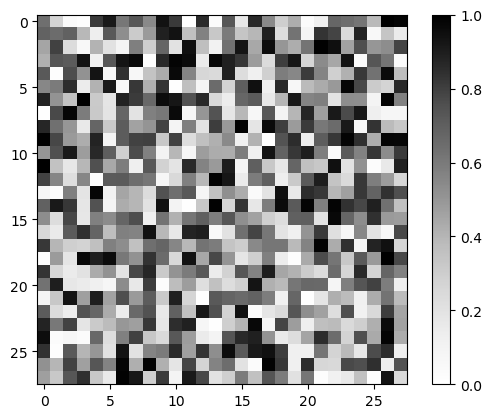

In [8]:
## Sample Random Input
import matplotlib.pyplot as plt
plt.imshow(RandomInputs[0], cmap="Greys", vmin=0.0, vmax=1.0)
plt.colorbar()
plt.show()

### Average Divergence

In [9]:
relu_scores = fashion_mlp.scores(RandomInputs)
conv_scores = conv_fashion.scores(RandomInputs)

tight_divergence        = np.max(np.abs(relu_scores - conv_scores), 0)
avg_tight_divergence    = np.sum(tight_divergence) / len(tight_divergence)

print("Avg. Tight Divergence:", avg_tight_divergence)

Avg. Tight Divergence: 19.595111083984374


### Worst Case Lower Bound

In [10]:
wc_lb_relu_score            = fashion_mlp.scores(np.zeros(fashion_mlp.in_shape))
wc_lb_conv_score            = conv_fashion.scores(np.zeros(fashion_mlp.in_shape))
diff                        = wc_lb_relu_score - wc_lb_conv_score
worst_lb_tight_divergence   = np.max(np.abs(diff))

print("Worst Case Lower Bound:", worst_lb_tight_divergence)

Worst Case Lower Bound: 24.869741


### Worst Case Upper Bound

In [11]:
conv_range_ub               = conv_fashion.propagate_bounds(InputDomain)[0][-1].ub
worst_ub_tight_divergence   = np.max(np.abs(conv_range_ub))

print("Worst Case Upper Bound:", worst_ub_tight_divergence)

Worst Case Upper Bound: 43.362710930551486


### Counting Misclassifications

In [12]:
relu_preds              = fashion_mlp.predict(RandomInputs)
conv_preds              = conv_fashion.predict(RandomInputs)
misclassifications      = np.array(relu_preds) != np.array(conv_preds)
misclassification_prob  = np.sum(misclassifications) / len(misclassifications)

print("Probability of Misclassification of the Tight Conv. Approximation:", misclassification_prob)

Probability of Misclassification of the Tight Conv. Approximation: 0.999


## Test on Test-Set Inputs

In [13]:
## Get random points
N                   = 1000
RandomTestInputs    = fashion_mlp.random_points(N)

We test some random Test-Set inputs, of the following form:

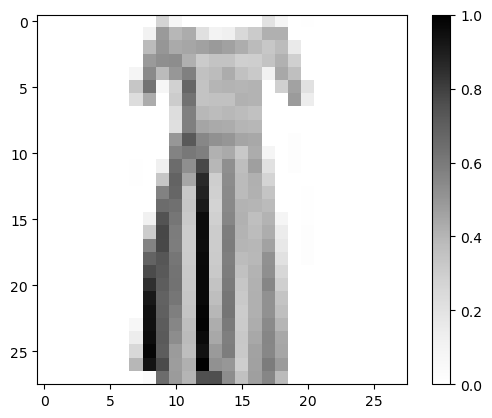

In [14]:
plt.imshow(RandomTestInputs[0], cmap="Greys", vmin=0.0, vmax=1.0)
plt.colorbar()
plt.show()

In [15]:
Sample              = RandomTestInputs[0]
sample_relu_score   = fashion_mlp.scores(Sample)
sample_conv_score   = conv_fashion.scores(Sample)
sample_relu_predict = fashion_mlp.predict(Sample)
sample_conv_predict = conv_fashion.predict(Sample)

sample_diff                = sample_relu_score - sample_conv_score
sample_tight_divergence    = np.max(np.abs(diff))

print("ReLU Sample score:\n", sample_relu_score)
print("Conv Sample score:\n", sample_conv_score)
print("Scores Tight Divergence:", sample_tight_divergence)
print("ReLU Sample Prediction:", sample_relu_predict[0])
print("Conv Sample Prediction:", sample_conv_predict[0])

ReLU Sample score:
 [[2.5827923  1.5018722  1.0095057  4.44126    0.5703067  0.
  1.3616868  0.5998446  0.17214766 0.        ]]
Conv Sample score:
 [[19.887283 22.811836 18.873129 19.101566 20.670084 25.685284 18.354208
  20.9369   20.514189 20.994911]]
Scores Tight Divergence: 24.869741
ReLU Sample Prediction: 3
Conv Sample Prediction: 5


### Average Divergence

In [18]:
test_relu_scores = fashion_mlp.scores(RandomTestInputs)
test_conv_scores = conv_fashion.scores(RandomTestInputs)

test_tight_divergence        = np.max(np.abs(test_relu_scores - test_conv_scores), 0)
test_avg_tight_divergence    = np.sum(test_tight_divergence) / len(test_tight_divergence)

print("Avg. Tight Divergence:", test_avg_tight_divergence)

Avg. Tight Divergence: 20.542344665527345


### Counting Misclassifications

In [17]:
test_relu_preds              = fashion_mlp.predict(RandomInputs)
test_conv_preds              = conv_fashion.predict(RandomInputs)
test_misclassifications      = np.array(test_relu_preds) != np.array(test_conv_preds)
test_misclassification_prob  = np.sum(test_misclassifications) / len(test_misclassifications)

print("Probability of Misclassification of the Tight Conv. Approximation:", test_misclassification_prob)

Probability of Misclassification of the Tight Conv. Approximation: 0.999
